# Spectroscopy Module

**Lecturer:** Robert Quimby<br>
**Jupyter Notebook Author:** Robert Quimby <br>
**With Contributions from:** Cameron Hummels, Matt Hankins, & Leo Singer

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2020.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2020.html

## Objective

Extract a 1-D spectrum from a 2-D image of a long-slit spectrum, determine wavelength solution, and then measure the redshift of the target.


## Key steps
- Define target and background apertures
- Subtract the background contribution from the target aperture
- Extract (sum) the counts in the background subtracted target aperture
- Determine the mapping between spectral bin number and wavelength (in Angstroms)
- Apply the wavelength solution to the target spectrum and find the observed wavelengths of emission lines
- Use the observed wavelengths and the known rest wavelengths to measure the target redshift

*Note: this notebook covers the steps necessary for a "quick and dirty" spectral extraction. For publication quality extractions see the included [Guide to Long-Slit Spectral Extractions](spectra_guide.ipynb)*

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib

### External packages
* None

In [1]:
# python modules that we will use
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

%matplotlib inline
import matplotlib.pylab as plt

In [3]:
from platform import python_version
# assert python_version() >= '3.6', "Python version 3.6 or greater is required for f-strings"

import scipy
# assert scipy.__version__ >= '1.4', "scipy version 1.4 or higher is required for this module"

In [4]:
print(python_version(),scipy.__version__) 

3.11.4 1.11.1


In [5]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (17, 7)

In [6]:
# where are the data located?
data_dir = '/ltzfs/ASTRO101/home/astro02/ASTRO101_data/Spectroscopy/data'

## Load the 2-D science Frame

Let's begin by looking at the 2D image of the science spectrum, `spec_sci.fits`.

In [7]:
# load the 2D science image data
image = fits.getdata(os.path.join(data_dir,'spec_sci.fits'))

In [8]:
# this is a helper function to display images in this notebook
def show_image(image, lower=-1, upper=3, extent=None):
    sample = sigma_clip(image)
    vmin = sample.mean() + lower * sample.std()
    vmax = sample.mean() + upper * sample.std()
    plt.figure(figsize=(15, 3))
    plt.imshow(image, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlabel('Column Number')
    plt.ylabel('Row Number');

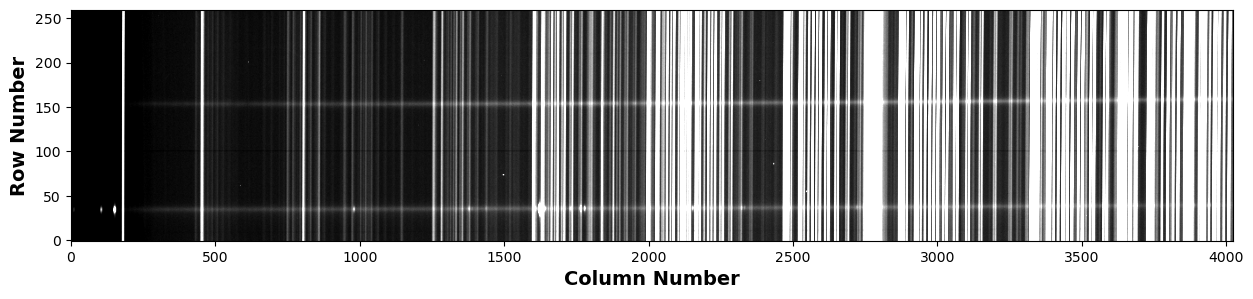

In [9]:
# display the image
show_image(image)

Take a look at the science image above. The supplied `spec_sci.fits` image is the red channel of a Keck/LRIS spectrum taken in 2014. The image has already been process to remove bias, and the image has been trimmed and rotated (what we will call "rows" are actually columns on the CCD). This science image is actually a combination of two individual exposures that has been filtered to remove **most** (but not quite all) cosmic ray events. 

Notice the vertical bands of light. These are the sky lines. The spectrum runs from about 5000 Angstroms on the left to about 10000 Angstroms on the right (you will determine the exact range below!). Notice that there is a significantly higher density of sky lines in the near infrared. 

Notice the two horizontal bands of light. The lower band is the target (a small galaxy), and the upper band is a second object in the slit. If you look closely at the lower band (the target trace), you will see a number of emission lines. You will use these to determine the target redshift.

## Determine which rows the target spans and which are background

We need to know which rows in the 2D image contain light from the target and which rows we can use to set the sky background. Plot the average counts in each row and then use this plot to set `row1` and `row2` roughly to the rows where the target is significantly brighter than the background to define the target aperture. Then set `bgrow1` and `bgrow2` to define the aperture for the sky background.

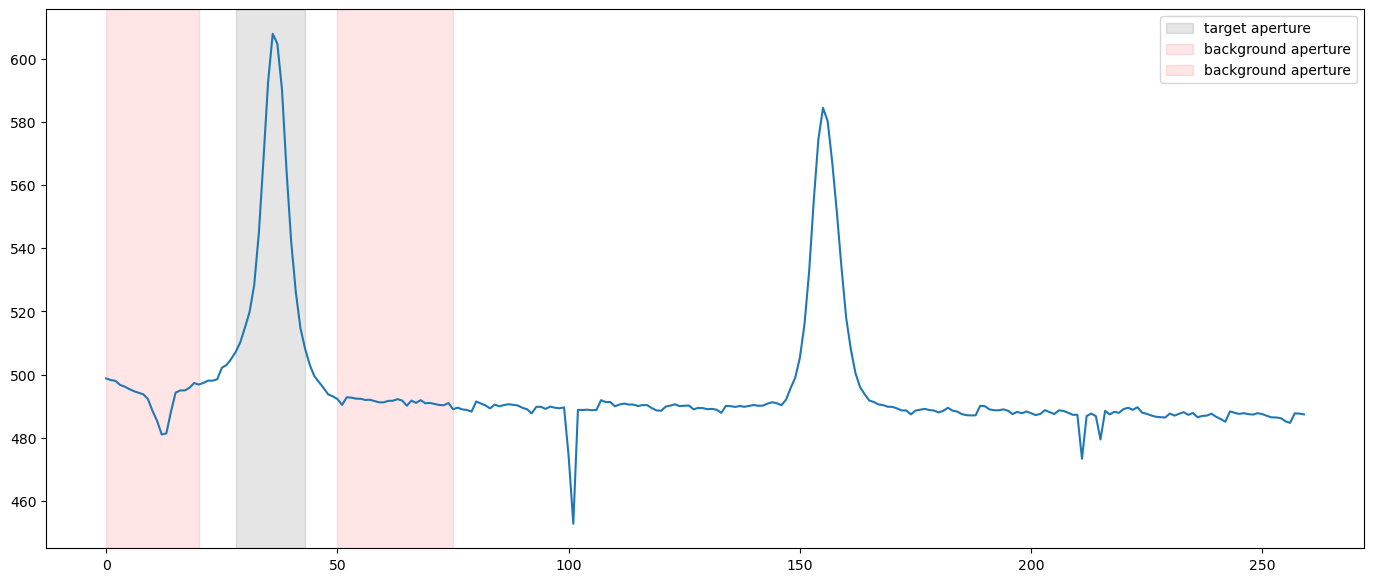

In [10]:
# plot the average of each row vs. row number
plt.plot(image.mean(axis=1))

# define the target aperture range
row1, row2 = 28, 43
plt.axvspan(row1, row2, color='k', alpha=0.1, label='target aperture')

# define the background aperture
# (it is best to have two bands--one on each side of the target aperture)
bg_apertures = []
bg_apertures.append((0, 20))
bg_apertures.append((50, 75))
for bgrow1, bgrow2 in bg_apertures:
    plt.axvspan(bgrow1, bgrow2, color='r', alpha=0.1, label='background aperture')

plt.legend();

## Quick and dirty sky subtraction

As with photometry, the target aperture will contain light from both the target and the sky, so we must subtraction the contribution from the sky background to obtain our target spectrum. An (imperfect) way to do this is to simply find the average value in each column of the background aperture and to subtract this value from the respective columns on the image.

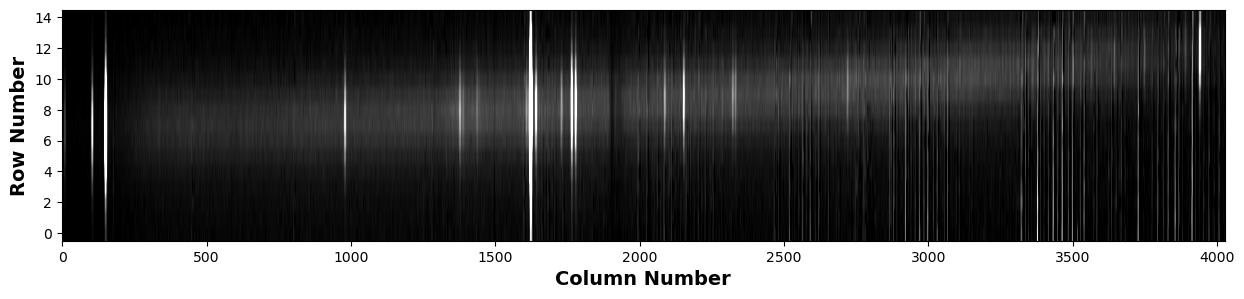

In [11]:
# create a mask to identify which pixels are *not* part of the background apertures
mask = np.ones(image.shape, dtype=bool)
for bgrow1, bgrow2 in bg_apertures:
    mask[bgrow1:bgrow2, :] = False

# use the mask to define a background image (as a numpy masked array)
bgim = np.ma.array(image, mask=mask)

# calculate the average value for each column in the background aperture
bgspec = np.ma.mean(bgim, axis=0)

# show the background subtracted target aperture
bgsubim = image - bgspec
show_image(bgsubim[row1:row2, :], upper=10)

You should now see the faint continuum of the target with a number of bright emission lines. You may also notice significant residuals from the bright sky lines. See the included [Guide to Long-Slit Spectral Extractions](spectra_guide.ipynb) for a better way to remove the sky background. 

## Quick and dirty spectral extraction

Now that we have a sky-subtracted image, we can take the sum of each column to extract our target spectrum.

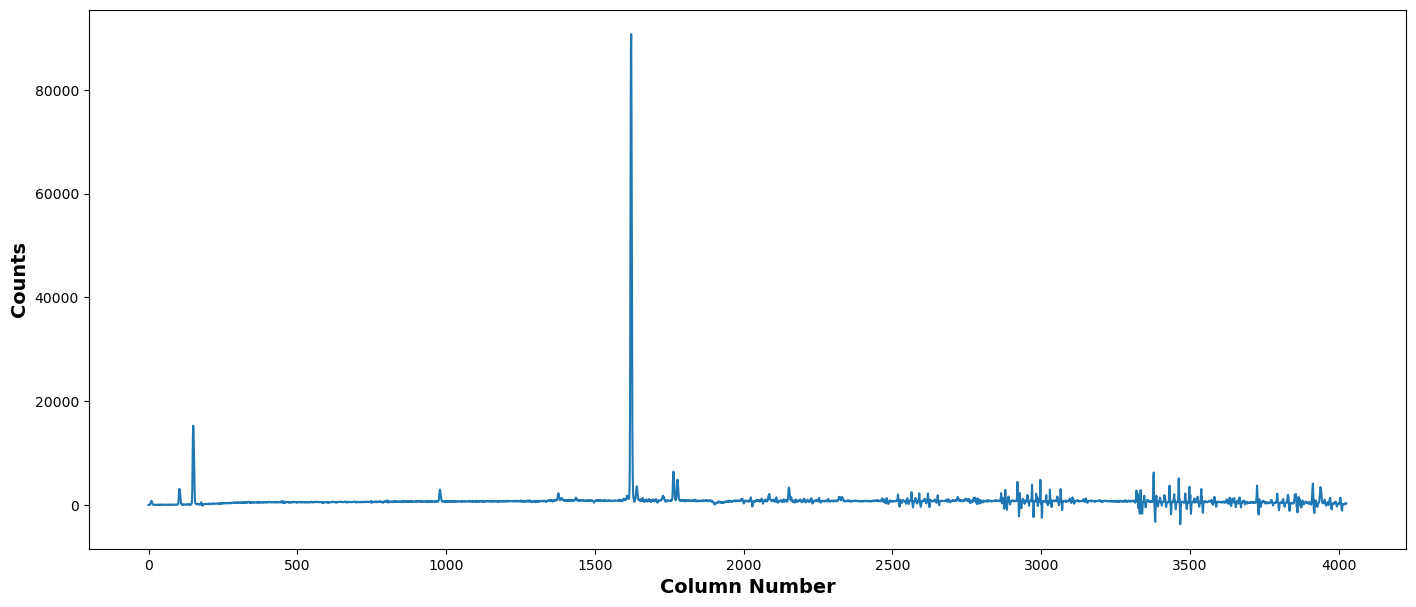

In [12]:
spec = np.sum(bgsubim[row1:row2, :], axis=0)
plt.plot(spec)
plt.xlabel('Column Number')
plt.ylabel('Counts');

You should see a strong emission line near the middle of the spectra, which is H-alpha, along with some weaker lines. Now we need to determine the observed wavelength of this line (this is often the hard part).

## Load the Lamp Spectra

To determine the mapping between column numbers and wavelengths (in Angstroms), we can make use of arc lamp spectra.

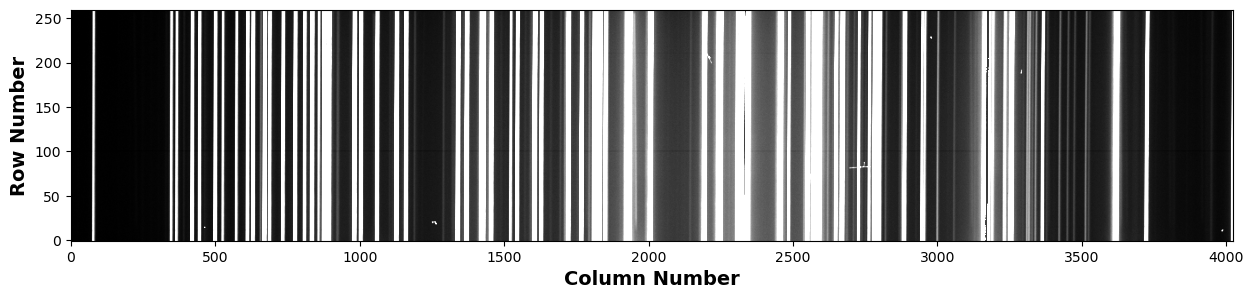

In [13]:
# load the 2D lamp image data
lamp_image = fits.getdata(os.path.join(data_dir,'spec_lamp.fits'))
show_image(lamp_image)

You should see that the lamp spectra consist of emission lines from the excited gas in the arc lamps (in this case mostly a combination of Neon and Argon). The wavelengths of these lines have been precisely measured in laboratory experiments, and we can use these known wavelengths and the columns where they are found to construct our wavelength solution. 

## Load the comparison line list

In [14]:
# load the "linelist" with precise laboratory wavelengths for these lamp lines
dtype = [('wav', float), ('id', 'U2')]
linelist = np.genfromtxt(os.path.join(data_dir, 'line_list.dat'), dtype=dtype)
linelist.sort(order='wav')

## Extract the lamp spectra in the same aperture as the target

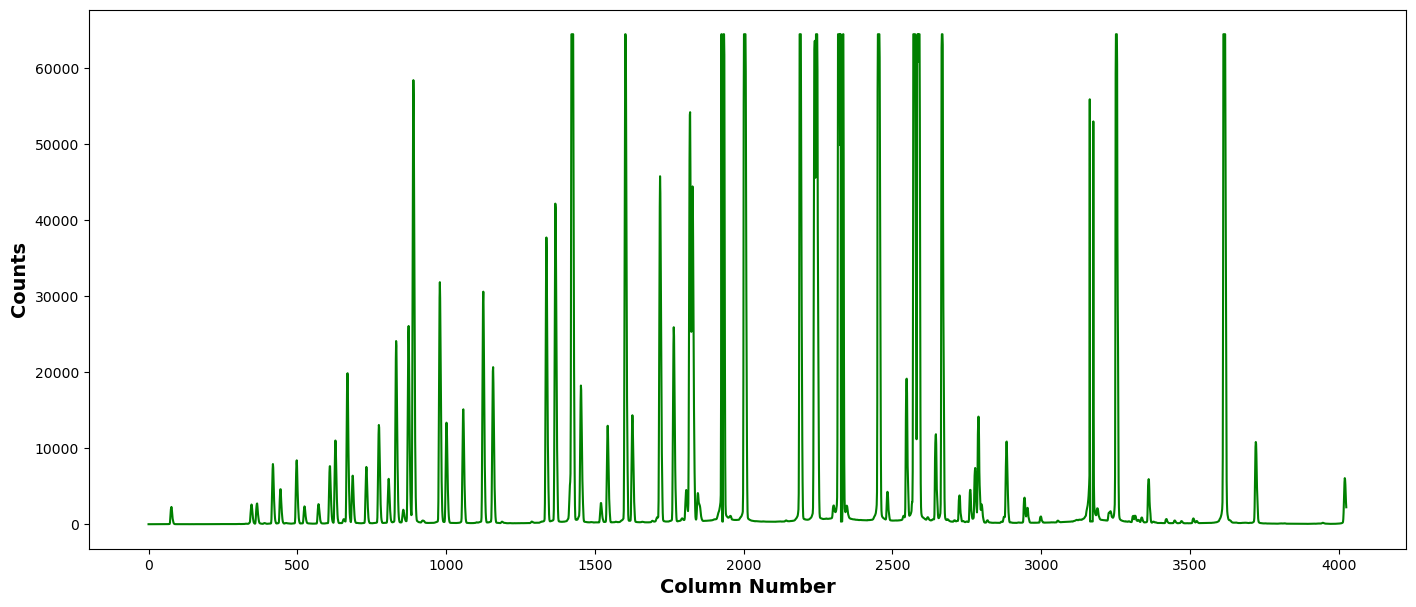

In [15]:
# use the same rows as for the target and extract the column averages
lamp_spec = lamp_image[row1:row2, :].mean(axis=0)
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylabel('Counts');

Notice that many of the lines peak at about 65000 counts? This indicates that these lines are saturated (too bright) and will not be useful for determining the wavelength solution.

## Identify each column where the flux peaks

We need the column value where each line peaks for our column to wavelength mapping. To start we can get approximate column values using `scipy.signal.find_peaks`. The keyword `prominence` is the desired minimum contrast (in counts) between the value at a peak and the value at the nearest troughs. Set this so that significant lines are kept but noise peaks are rejected. 

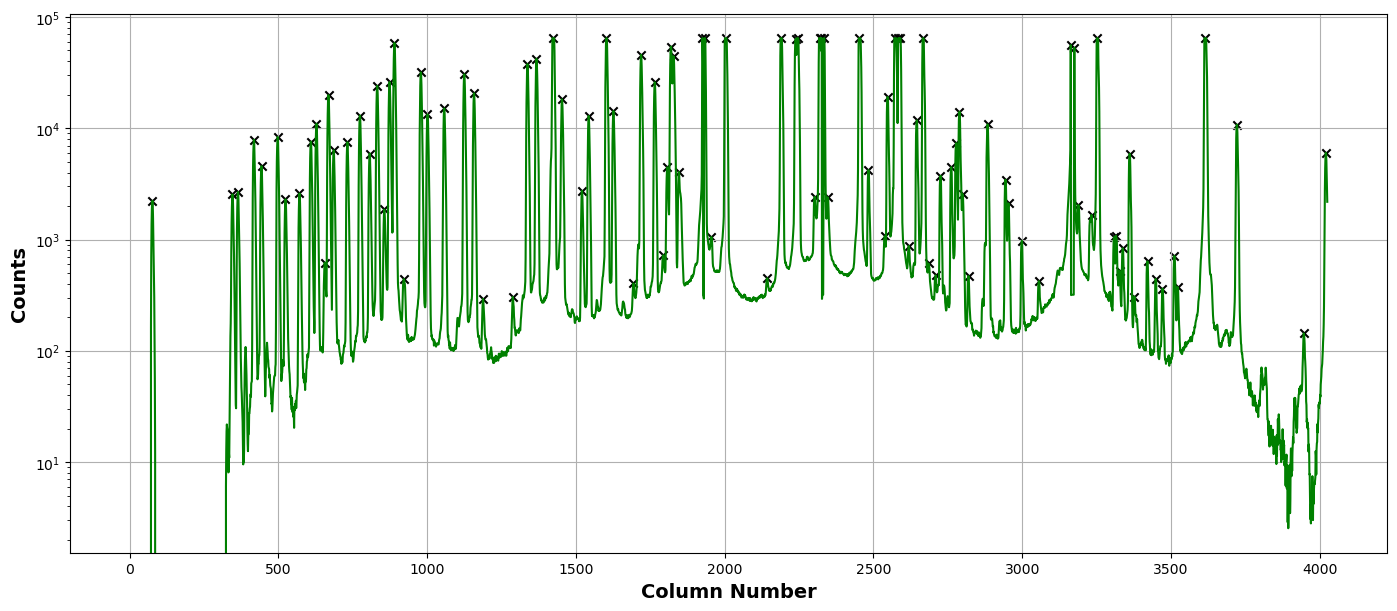

In [16]:
# locate approximate line centers
prominence = 100
peak_cols, properties = find_peaks(lamp_spec, prominence=prominence)

# plot the spectra
plt.plot(lamp_spec, c='g')

# mark the peaks
plt.scatter(peak_cols, lamp_spec[peak_cols], marker='x', c='k')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid();

The `find_peaks` function merely returns integer indices into the `lamp_spec` array. We can fit Gaussian models to each one of these peaks to find the line centers to much better than 1 column. 

In [17]:
# use a Gaussian function to model spectral lines
def gaussian(x, *params):
    amp, x0, sigma = params
    return amp * np.exp(-(x - x0)**2 / 2 / sigma**2)

In [18]:
# define a function to determine the precise column centers for each lamp line
def get_lamp_lines(lamp_spec, prominence=100):
    peak_cols, properties = find_peaks(lamp_spec, prominence=prominence)

    # record in a structured array for convenience 
    dtype = []
    dtype.append( ('col', float) )
    dtype.append( ('counts', float) )
    dtype.append( ('x', float) )
    dtype.append( ('y', float) )
    dtype.append( ('sigma', float) )
    dtype.append( ('id', 'U2') )
    dtype.append( ('wav', float) )
    dtype.append( ('wavres', float) )
    dtype.append( ('used', bool) )
    lamp_lines = np.zeros(peak_cols.size, dtype=dtype)
    lamp_lines['col'] = peak_cols
    lamp_lines['counts'] = lamp_spec[peak_cols]
    lamp_lines['x'] = np.nan
    lamp_lines['y'] = np.nan
    lamp_lines['sigma'] = np.nan
    lamp_lines['wav'] = np.nan
    lamp_lines['wavres'] = np.nan

    # fit each peak to determine precise center
    cols = np.arange(lamp_spec.size)
    sigma_guess = 2.5
    for line in lamp_lines:
        if line['counts'] > 60000:
            # line is saturated...skip
            continue

        i0 = max([0, int(line['col'] - 5)])
        i1 = min([lamp_spec.size - 1, int(line['col'] + 5)])
        guess = (line['counts'], line['col'], sigma_guess)
        bounds = ((0, line['col'] - 3, 0), (np.inf, line['col'] + 3, np.inf))
        try:
            popt, pcov = curve_fit(gaussian, cols[i0:i1], lamp_spec[i0:i1], p0=guess, bounds=bounds)
        except RuntimeError:
            # curve_fit failed to converge...skip
            continue

        line['x'] = popt[1]
        line['y'] = gaussian(popt[1], *popt)
        line['sigma'] = popt[2]

    # filter lamp_lines to keep only lines that were fit
    wasfit = np.isfinite(lamp_lines['x'])
    lamp_lines = lamp_lines[wasfit]
    print('found center pixel values for', lamp_lines.size, 'lines')
    return lamp_lines

In [19]:
# helper function to mark lamp lines with and 'x'
def mark_peaks(plt, lamp_lines, xtype='x', ytype='y', c='k'):
    w = np.isfinite(lamp_lines['wav'])
    if w.sum() > 0:
        plt.scatter(lamp_lines[xtype][w], lamp_lines[ytype][w], c=np.abs(lamp_lines['wavres'][w]), zorder=10)
    if (~w).sum() > 0:
        plt.scatter(lamp_lines[xtype][~w], lamp_lines[ytype][~w], c=c, marker='x')

found center pixel values for 82 lines


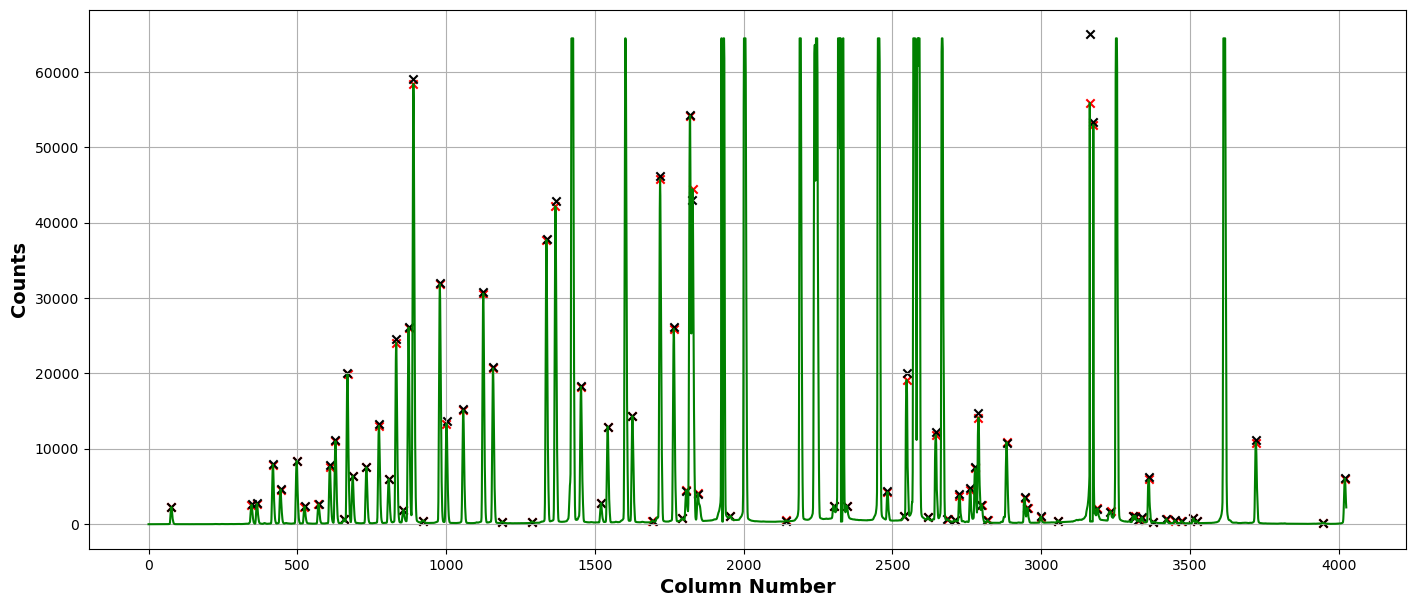

In [20]:
# find the precise column centers for all lamp lines
lamp_lines = get_lamp_lines(lamp_spec, prominence=prominence)

# plot the lamp spectra
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.grid()

# mark initial values from find_peaks in red
mark_peaks(plt, lamp_lines, 'col', 'counts', c='r')

# mark best-fit values
mark_peaks(plt, lamp_lines)

## Load reference spectrum

Now that we have precise column centers for each line, we need to identify each line to set its wavelength. We can begin by looking for similar line features in a wavelength calibrated lamp spectrum atlas. 

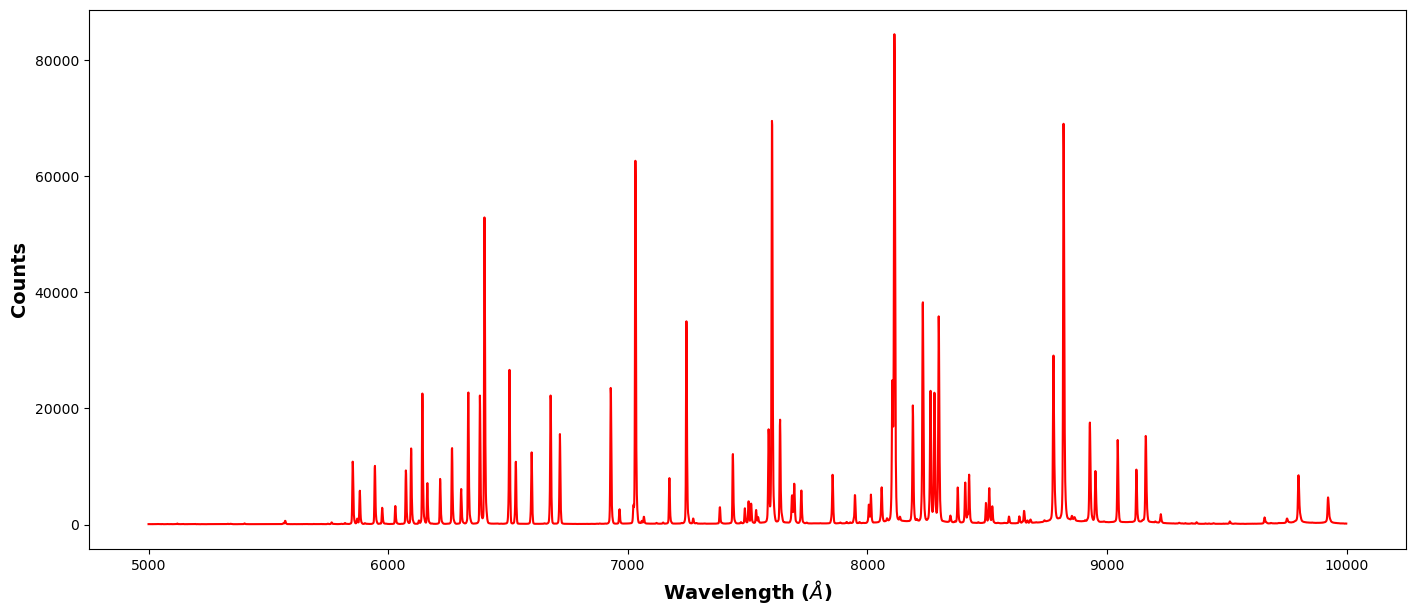

In [21]:
# load and plot the provided spectral atlas
lamp_ref = np.genfromtxt(os.path.join(data_dir, 'lamp_reference.dat'), names='wav, counts')
plt.plot(lamp_ref['wav'], lamp_ref['counts'], c='r')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

## Define a rough mapping between column number and wavelength

In [22]:
# this function will be used below to match a given line to a given list
def match_to_list(listing, values, plt=None, tol=None, revcoeff=None, c='k'):
    matched = []
    cols = []
    for value in values:
        absdiff = np.abs(value - listing)
        ind = np.argmin(absdiff)
        if tol is None:
            bestmatch = listing[ind]
        elif absdiff[ind] < tol:
            bestmatch = listing[ind]
        else:
            bestmatch = np.nan
        matched.append(bestmatch)

        if plt is not None:
            plt.axvline(bestmatch, ls='dotted', c=c)
            
        if revcoeff is not None:
            col = np.polyval(revcoeff, bestmatch)
            cols.append(col)
            print(f"{bestmatch:.1f} is expected near column {col:.0f}")

    if revcoeff is not None:
        return np.array(matched), cols
    
    return np.array(matched)

Focus on a small wavelength range of the reference spectrum (between `wav1` and `wav2`). Pick a few good (non-blended) lines to start with.

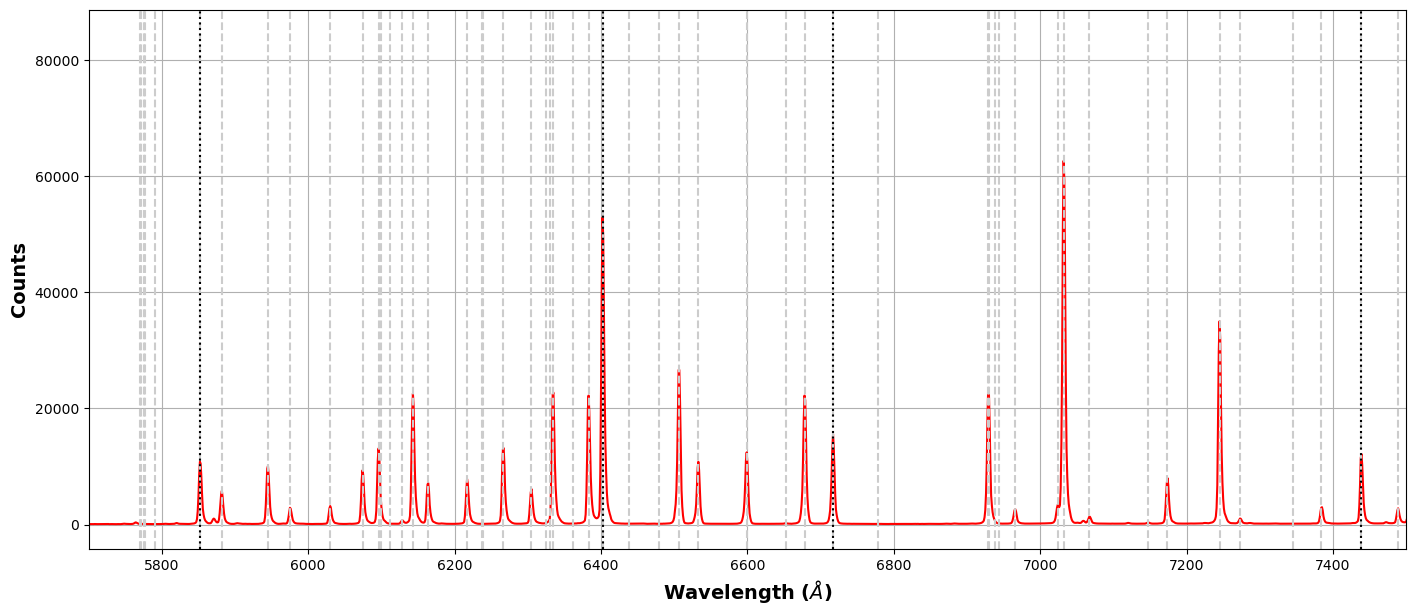

In [23]:
wav1 = 5700
wav2 = 7500

# plot the reference spectrum in red
plt.plot(lamp_ref['wav'], lamp_ref['counts'], label='reference', c='r')
plt.xlim(wav1, wav2)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts'); plt.grid();

# mark all wavelengths available in linelist
for row in linelist:
    plt.axvline(row['wav'], ls='dashed', c='0.8')

# pick a few lines in this plot
rough_waves = [5850, 6410, 6730, 7450]
refwavs = match_to_list(linelist['wav'], rough_waves, plt=plt)

Now try to find a section of your `lamp_spec` (between columns `col1` and `col2`) that looks similar.

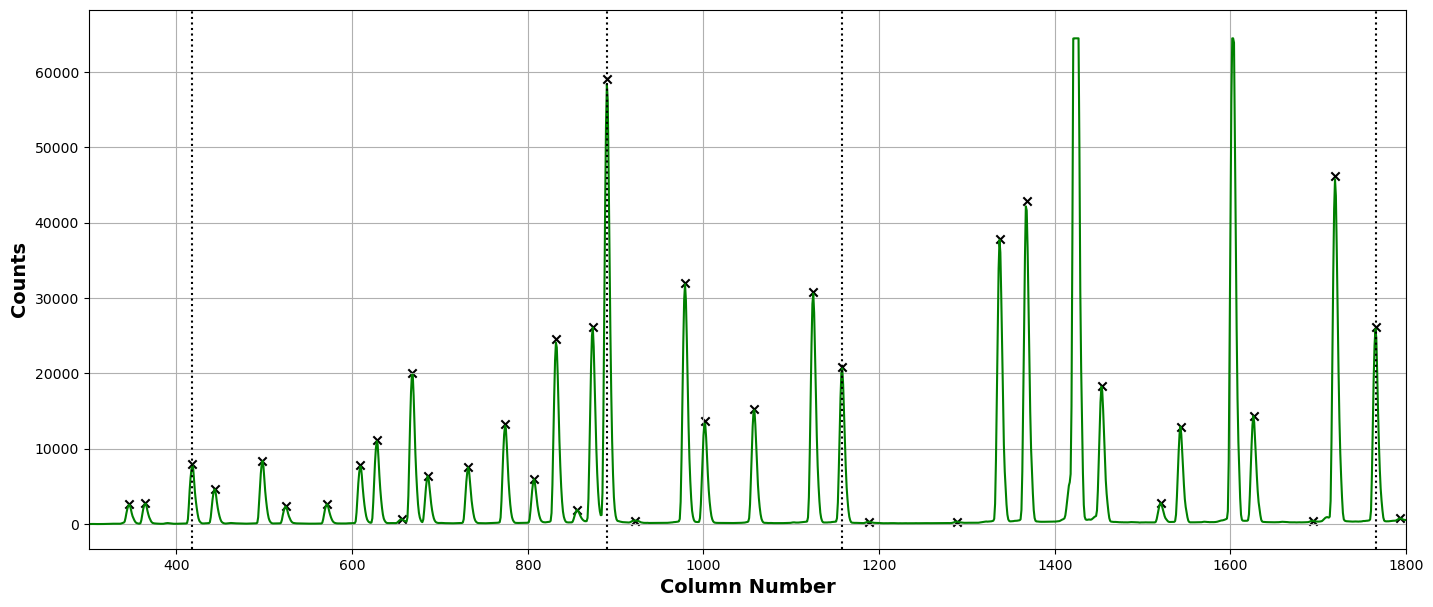

In [24]:
# find a section of lamp_spec that looks similar
col1 = 300
col2 = 1800
plt.plot(lamp_spec, c='g')
plt.xlim(col1, col2)
plt.xlabel('Column Number'); plt.ylabel('Counts'); plt.grid()

# mark lines with Gaussian-fit centers
mark_peaks(plt, lamp_lines)

# record the rough column numbers of the same lines as above in the same order
rough_cols = [410, 890, 1150, 1750]
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)

When you have marked 3-4 matching lines, use the cells below to record the line wavelengths in `lamp_lines`.

In [25]:
def set_line_identity(lamp_lines, linelist, x, wav):
    # find the closest matching lamp_line
    ilamp = np.argmin(np.abs(lamp_lines['x'] - x))
    
    # find the closest matching row in the linelist
    ilist = np.argmin(np.abs(linelist['wav'] - wav))
    
    # reset values in lamp_lines
    lamp_lines[ilamp]['id'] = linelist[ilist]['id']
    lamp_lines[ilamp]['wav'] = linelist[ilist]['wav']

In [26]:
# record ids and wavelengths of matched lines
for col, wav in zip(refcols, refwavs):
    set_line_identity(lamp_lines, linelist, col, wav)

## Set the initial wavelength solution

Using the matched column/wavelength pairs we can define an initial wavelength solution by assuming a polynomial (linear to start) relation.

In [27]:
# this routine finds the polynomial coefficients needed to transform between 
# column numbers and wavelengths (and vice versa). Outlier rejection is included.
def get_wavelength_solution(lamp_lines, order=4):
    wfit = np.isfinite(lamp_lines['wav'])
    
    # define the reverse mapping (wavelength to column)
    revcoeff = np.polyfit(lamp_lines['wav'][wfit], lamp_lines['x'][wfit], order)

    # define the forward mapping (column to wavelength)
    coeff = np.polyfit(lamp_lines['x'][wfit], lamp_lines['wav'][wfit], order)
    
    # check the fit for outliers
    fit_wav = np.polyval(coeff, lamp_lines['x'])
    wavres = fit_wav - lamp_lines['wav']
    lamp_lines['wavres'] = wavres
    sample = wavres[wfit]
    sample.sort()
    sample = sample[int(0.1 * sample.size) : int(0.9 * sample.size + 0.5)]    
    std = np.std(sample, ddof=1)
    w = wfit 
    w[wfit] = (np.abs(lamp_lines['wavres'][wfit]) < (5 * std))
    if w.sum() != lamp_lines.size:
        # re-fit with outliers rejected
        coeff, revcoeff = get_wavelength_solution(lamp_lines[w], order=order)
        
        # reset wavelength residuals using new coefficients
        fit_wav = np.polyval(coeff, lamp_lines['x'])
        wavres = fit_wav - lamp_lines['wav']
        lamp_lines['wavres'] = wavres
        
    lamp_lines['used'] = w
    return coeff, revcoeff
        
def check_wavelength_solution(lamp_spec, lamp_lines, coeff):    
    wavs = col_to_wav(coeff, np.arange(lamp_spec.size))
    plt.plot(wavs, lamp_spec, c='g', lw=2)
    mark_peaks(plt, lamp_lines, 'wav')
    plt.colorbar(label='Residual ($\AA$)')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Counts')
    plt.grid()
    
def col_to_wav(coeff, cols):
    return np.polyval(coeff, cols)

def wav_to_col(revcoeff, wavs):
    return np.polyval(revcoeff, wavs)

def mark_matched(lamp_lines):
    for line in lamp_lines:
        plt.axvline(line['wav'], ls='dotted', c='k')

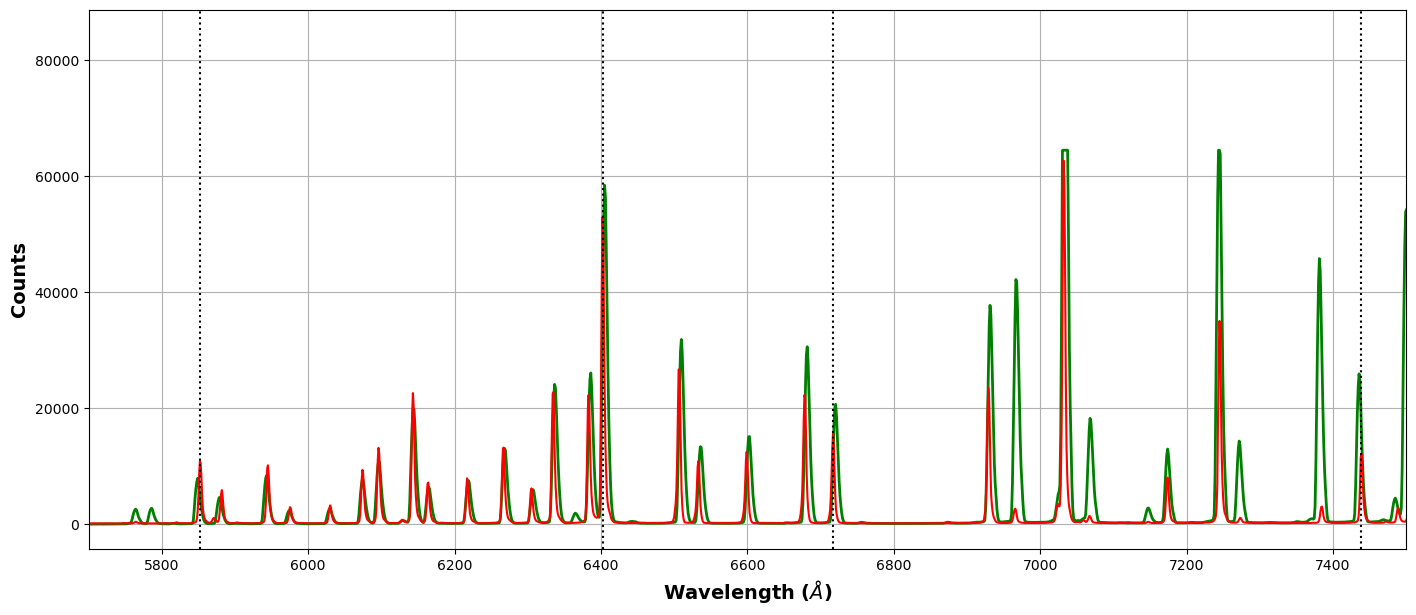

In [28]:
# estimate a linear relation between column number and wavlength
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=1)

# apply the wavelength solution to the column numbers
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))

# plot the initial wavelength calibrated spectrum
plt.plot(wavs, lamp_spec, c='g', lw=2, label='lamps')
plt.xlim(wav1, wav2)

# plot the reference spectrum in red
plt.plot(lamp_ref['wav'], lamp_ref['counts'], label='reference', c='r')
plt.xlim(wav1, wav2)
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts'); plt.grid();
mark_matched(lamp_lines)

## Use the initial wavelength solution to match more lines

In [29]:
# check for more matches in the range already fit
def match_more(lamp_lines, linelist, order=4, tol=2):
    coeff, revcoeff = get_wavelength_solution(lamp_lines, order=order)
    wfit = np.isfinite(lamp_lines['wav'])
    minwav = lamp_lines['wav'][wfit].min()
    maxwav = lamp_lines['wav'][wfit].max()
    
    xmin = lamp_lines['x'][wfit].min()
    xmax = lamp_lines['x'][wfit].max()
    
    w = (lamp_lines['x'] > xmin) & (lamp_lines['x'] < xmax)
    for line in lamp_lines[w]:
        rough_wav = col_to_wav(coeff, line['x'])
        refwav = match_to_list(linelist['wav'], [rough_wav], tol=tol)
        if np.isfinite(refwav):
            #print(f'matched column {line["x"]:.1f} to wavelength {refwav[0]}')
            set_line_identity(lamp_lines, linelist, line['x'], refwav)
            
match_more(lamp_lines, linelist, order=1)

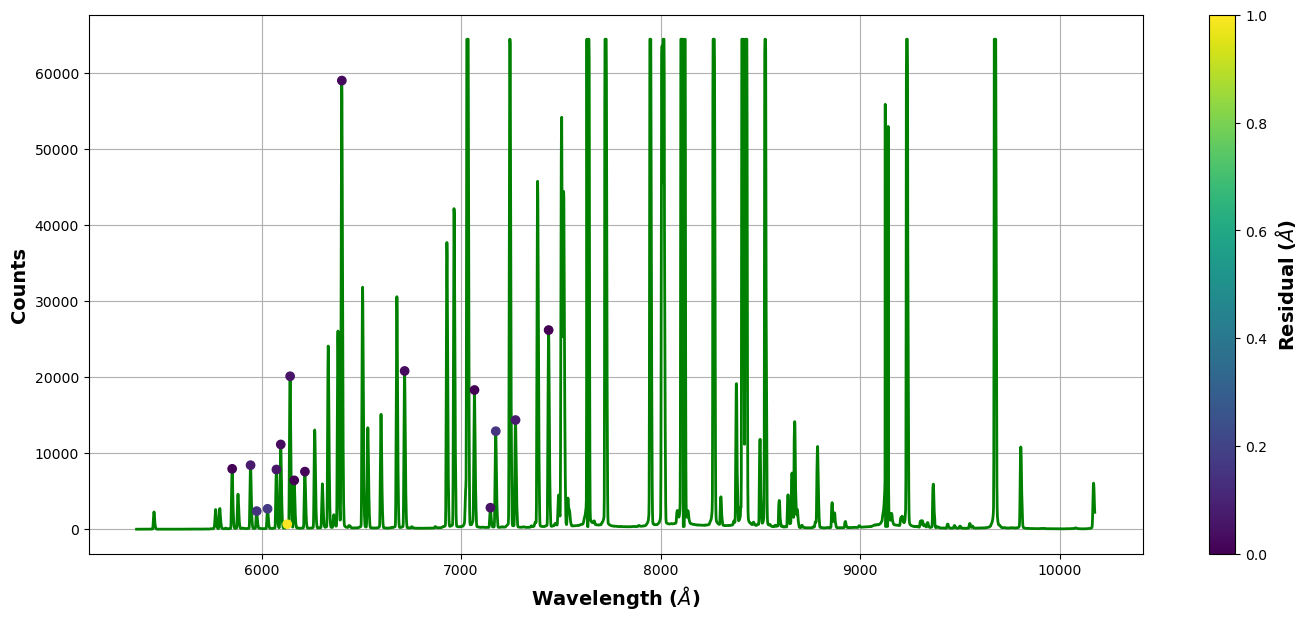

In [30]:
# re-fit with a higher order
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=4)
check_wavelength_solution(lamp_spec, lamp_lines, coeff)

## Use the revised wavelength solution to extend the range of matches

Pick lines near the ends of the spectra to extend the solution across the full wavelength range.

5460.7 is expected near column 77
9784.5 is expected near column 3701


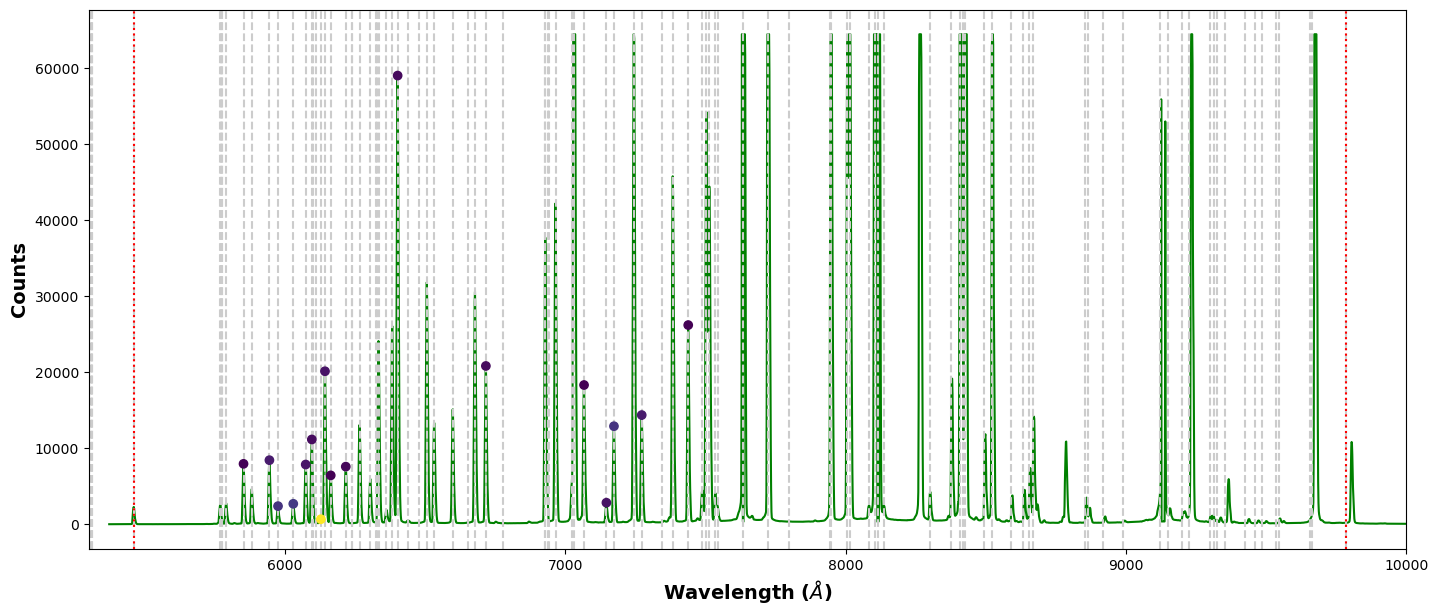

In [31]:
wav1 = 5300
wav2 = 10000

# plot line list over lamp spectra
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))
plt.plot(wavs, lamp_spec, c='g')
plt.xlim(wav1, wav2)

# show available lines in the line list with dashed grey lines
for row in linelist:
    plt.axvline(row['wav'], ls='dashed', c='0.8')

# pick new lines to add
rough_waves = [5460, 9790] #[6960,  7170, 7440, 8380] # 7060, 7270, 
refwavs, rough_cols = match_to_list(linelist['wav'], rough_waves, plt=plt, revcoeff=revcoeff, c='r')
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)

# mark existing matches
mark_peaks(plt, lamp_lines, 'wav')
#plt.scatter(lamp_lines['wav'], lamp_lines['y'], c=np.abs(lamp_lines['wavres']));
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts');

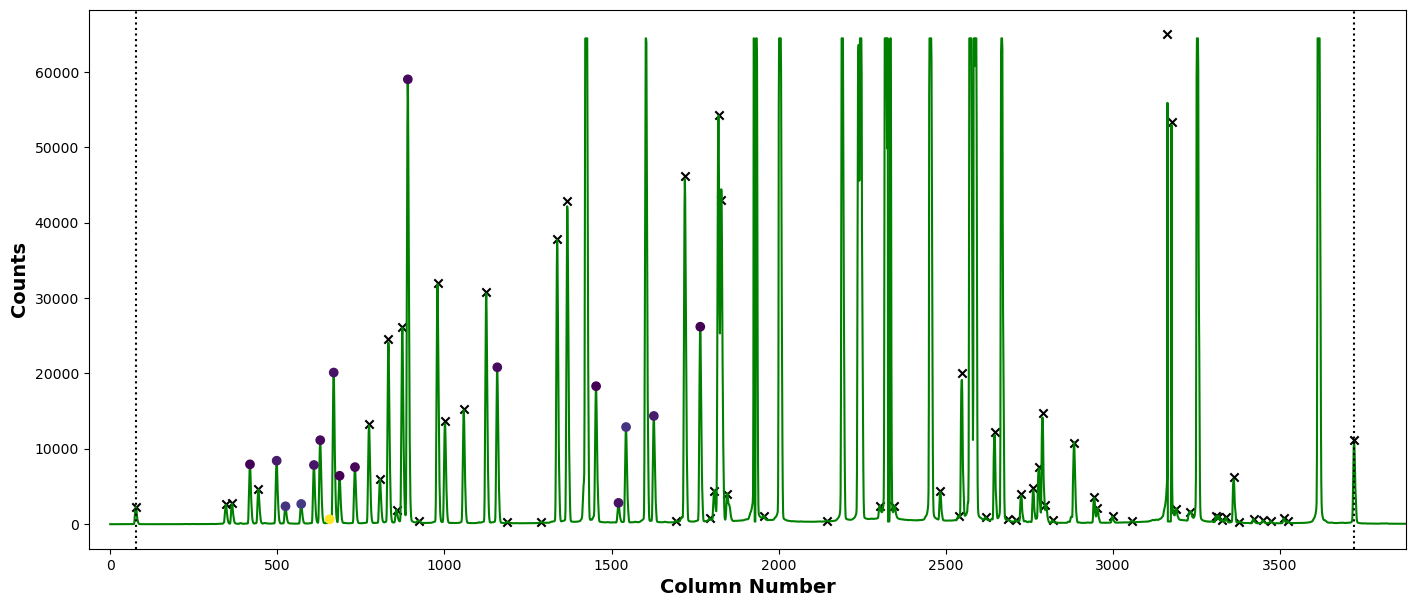

In [32]:
# check the supposed matches
col1, col2 = np.polyval(revcoeff, [wav1, wav2])
refcols = match_to_list(lamp_lines['x'], rough_cols)

plt.plot(lamp_spec, c='g')
mark_peaks(plt, lamp_lines, 'x', 'y')

plt.xlim(col1, col2)
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)
plt.xlabel('Column Number'); plt.ylabel('Counts');

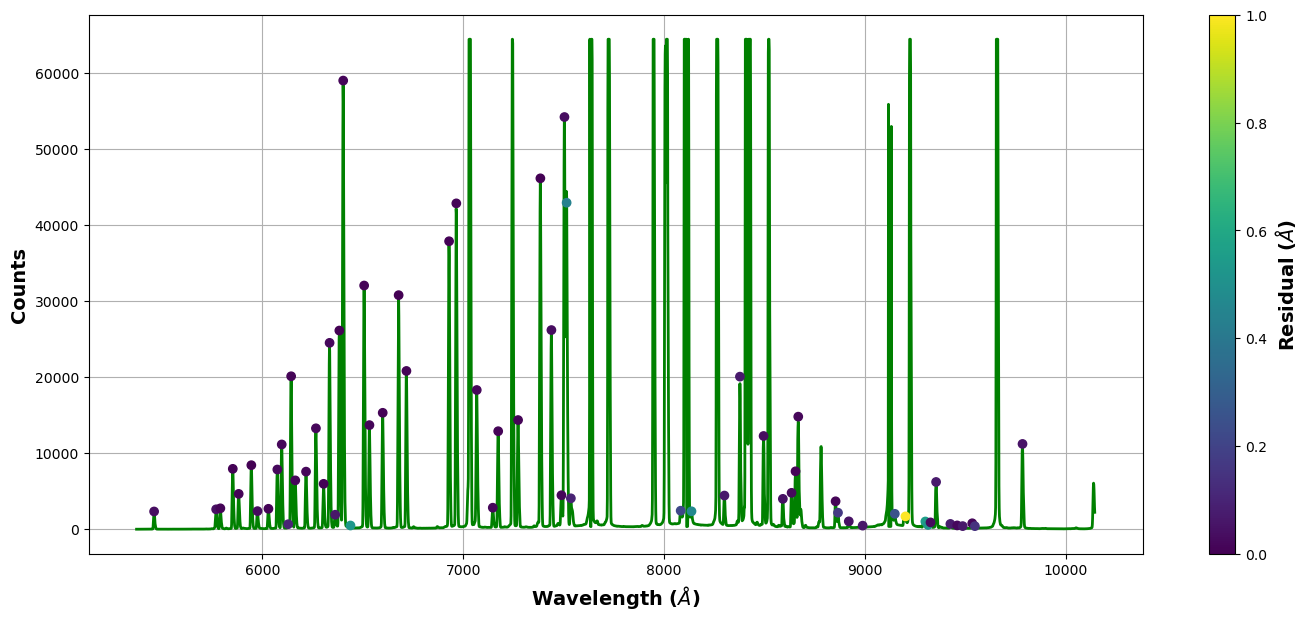

In [33]:
# add new lines to the matches
for col, wav in zip(refcols, refwavs):
    set_line_identity(lamp_lines, linelist, col, wav)
    
# auto-match more lines
match_more(lamp_lines, linelist)

# re-fit
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=4)
check_wavelength_solution(lamp_spec, lamp_lines, coeff)

## Plot wavelength residuals

Make sure you have a good wavelength solution by checking the residuals. For the supplied Keck/LRIS data, the wavelength solution should be accurate to a fraction of an Angstrom.

STD of wavelength residual is 0.17 Angstrom


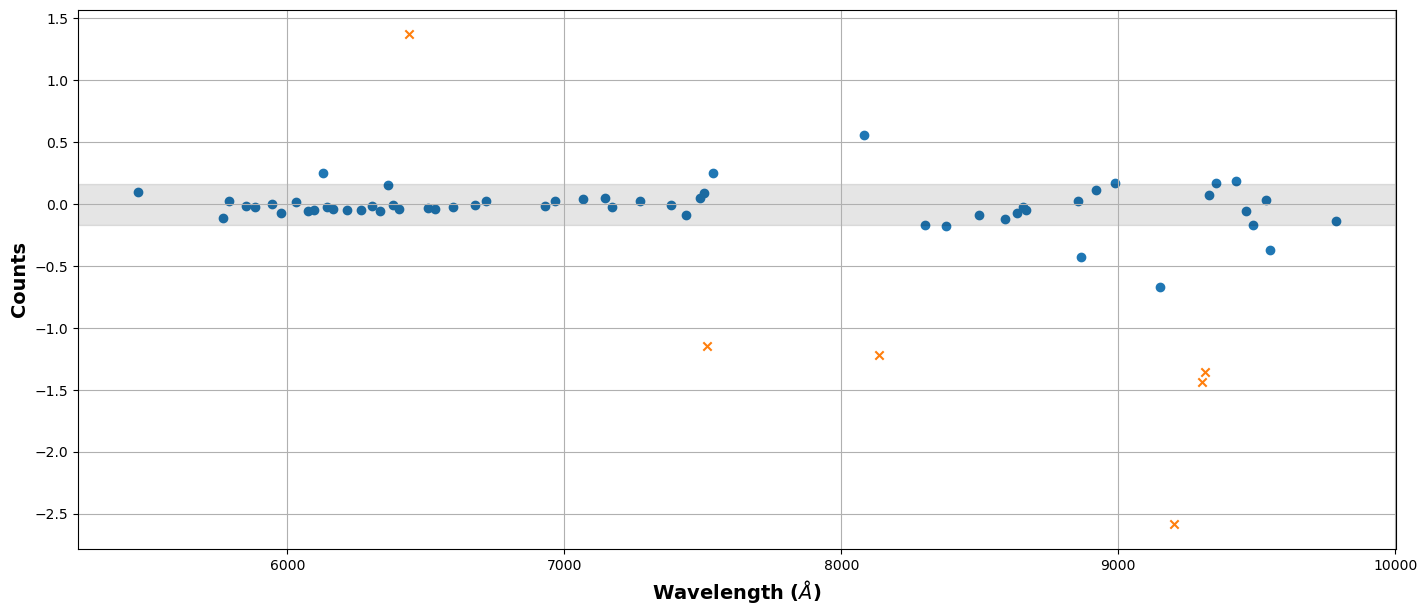

In [34]:
w = lamp_lines['used']
std = np.std(lamp_lines['wavres'][w], ddof=1)
print(f'STD of wavelength residual is {std:0.2} Angstrom')

plt.scatter(lamp_lines['wav'][w], lamp_lines['wavres'][w]) #, c=np.abs(lamp_lines['wavres'][w]))
plt.scatter(lamp_lines['wav'][~w], lamp_lines['wavres'][~w], marker='x') #c=np.abs(lamp_lines['wavres'][~w]))
plt.axhspan(-std, std, color='k', alpha=0.1)
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts'); plt.grid();

## Plot target spectra vs. wavelength

We can apply the wavelength solution from the arc lamps to the science spectra to produce a wavelength calibrated science spectrum. Note that it is possible for there to be a wavelength offset between the arc lamp and science spectra. See the included [Guide to Long-Slit Spectral Extractions](spectra_guide.ipynb) for a procedure to correct for this shift. 

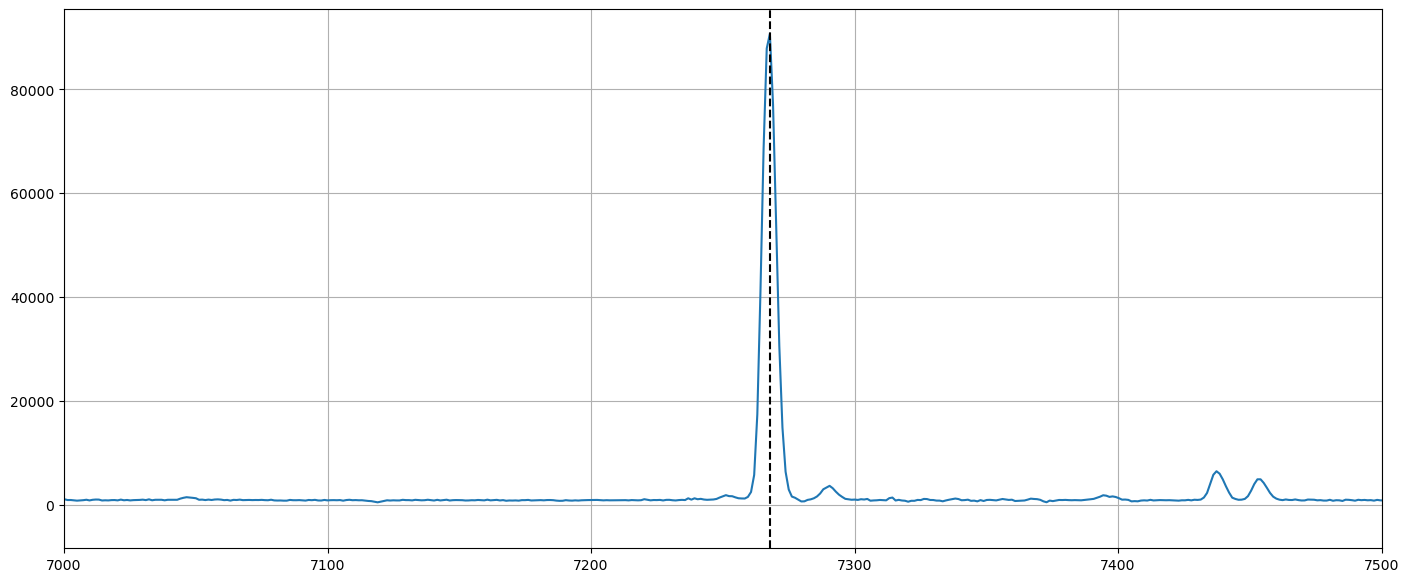

In [35]:
# calculate the wavelengths for each column number
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))

# plot the spectra
plt.plot(wavs, spec);

# zoom in on H-alpha
plt.xlim(7000, 7500)
plt.grid()

# make a guess at the central wavelength
obswav_guess = 7268
plt.axvline(obswav_guess, ls='dashed', c='k');

## Measure the observed wavelength of H$\alpha$

You can assume the same Gaussian line model used above to fit for the precise line center.

In [36]:
# fit a Gaussian to find line center
guess = 6000, obswav_guess, 2.5
bounds = ((0, obswav_guess - 25, 0), (np.inf, obswav_guess + 25, np.inf))
popt, pcov = curve_fit(gaussian, wavs, spec, p0=guess, bounds=bounds)

obswav = popt[1]
obswav_error = np.sqrt(pcov[1, 1])
print(f'Observed wavelength of H-alpha is {obswav:.3f} +/- {obswav_error:.3f}')

Observed wavelength of H-alpha is 7267.565 +/- 0.021


In [37]:
# use the known laboratory wavelength to determine the redshift
restwav = 6562.78
redshift = obswav / restwav - 1
redshift_error = np.hypot(obswav_error, std) / restwav
print(f'The redshift is {redshift:.5f} +/- {redshift_error:.5f}')

The redshift is 0.10739 +/- 0.00003


## [Optional] use other lines in the spectrum to test redshift

# [Optional] Going Further: Publication Quality Spectral Extraction

Following the steps in this notebook you should now have a measurement for the redshift of the target. For many applications this is all you will need, but there are a number of improvements that can be made as well as additional steps that can be followed to produce a fully reduced, publication quality spectrum. See the included [Guide to Long-Slit Spectral Extractions](spectra_guide.ipynb) for the complete guide.